In [1]:
import numpy as np
import librosa
import soundfile as sf
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.signal import lfilter, freqz
from scipy.linalg import toeplitz

In [2]:
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wavfile
import speech_recognition as sr
import wave  # used for writing the WAV file.

In [3]:
class SpeechProcessor:
    def __init__(self, duration=5, fs=44100):
        """
        Initialize the SpeechProcessor with recording parameters.
        :param duration: Duration of the audio to record in seconds.
        :param fs: Sampling rate (Hz) for the recording.
        """
        self.duration = duration
        self.fs = fs
        self.recognizer = sr.Recognizer()  # Initialize the recognizer
        self.audio_file = None  # Will store the path to the recorded file

    def record_speech(self):
        """
        Record audio for a specified duration using sounddevice and save it as a 16-bit PCM WAV.
        """
        try:
            print("Recording...")
            audio = sd.rec(int(self.duration * self.fs), samplerate=self.fs, channels=1, dtype='int16')  # Save as 16-bit PCM
            sd.wait()  # Wait until recording is finished
            print("Recording finished.")
            
            # Save the recorded audio as a 16-bit PCM WAV file
            self.audio_file = 'YourAudio.wav'
            with wave.open(self.audio_file, 'wb') as wf:
                wf.setnchannels(1)  # Mono channel 
                wf.setsampwidth(2)  # 2 bytes = 16 bits
                wf.setframerate(self.fs)
                wf.writeframes(audio.tobytes())  # Convert to bytes and write to file

            return self.audio_file  # Return the filename for further processing

        except sd.PortAudioError as e:
            print(f"Error recording audio: {e}")
            return None

        except Exception as e:
            print(f"Unexpected error occurred during recording: {e}")
            return None

    def convert_speech_to_text(self):
        """
        Convert recorded audio file to text using Google's Web Speech API.
        """
        if not self.audio_file:
            print("No audio file recorded yet.")
            return None

        try:
            # Use recognizer to open and recognize the speech in the wav file
            with sr.AudioFile(self.audio_file) as source:
                audio = self.recognizer.record(source)  # Record the audio from the file
            print("Recognizing...")
            text = self.recognizer.recognize_google(audio)
            print(f"Speech recognized: {text}")
            return text

        except sr.UnknownValueError:
            print("Speech Recognition could not understand audio. Please try speaking more clearly.")
            return None

        except sr.RequestError:
            print("Could not connect to the recognition service. Please check your internet connection.")
            return None

        except FileNotFoundError:
            print("The recorded audio file could not be found.")
            return None

        except Exception as e:
            print(f"An unexpected error occurred during speech recognition: {e}")
            return None

    def get_audio_file(self):
        """
        Returns the file path of the recorded audio file.
        """
        if self.audio_file:
            return self.audio_file
        else:
            print("No audio has been recorded yet.")
            return None

    def display_text(self, text):
        """
        Display the recognized text.
        """
        if text:
            print(f'Speech successfully converted to text: "{text}"')
        else:
            print("Speech conversion failed.")

    def process(self):
        """
        The main process that records audio, converts to text, and displays the result.
        """
        # Step 1: Record the speech
        audio_file = self.record_speech()
        
        if audio_file:
            # Step 2: Convert the recorded audio to text
            text = self.convert_speech_to_text()
            
            # Step 3: Display the converted text
            self.display_text(text)
        else:
            print("Audio recording failed, cannot proceed with speech recognition.")

'''# Example of how to use the SpeechProcessor class
if __name__ == "__main__":
    try:
        processor = SpeechProcessor(duration=5)  # Set the desired duration
        processor.record_speech()  # Record the speech
        
        # Attempt to retrieve the audio file
        audio_file = processor.get_audio_file()
        if audio_file:
            print(f"Audio file saved at: {audio_file}")
        else:
            print("Audio file retrieval failed.")

    except Exception as e:
        print(f"An unexpected error occurred during the process: {e}")'''

'# Example of how to use the SpeechProcessor class\nif __name__ == "__main__":\n    try:\n        processor = SpeechProcessor(duration=5)  # Set the desired duration\n        processor.record_speech()  # Record the speech\n        \n        # Attempt to retrieve the audio file\n        audio_file = processor.get_audio_file()\n        if audio_file:\n            print(f"Audio file saved at: {audio_file}")\n        else:\n            print("Audio file retrieval failed.")\n\n    except Exception as e:\n        print(f"An unexpected error occurred during the process: {e}")'

In [4]:
def get_audio_choice():
    choice = input("Do you want to record a new speech signal or upload a file? (record/upload): ").strip().lower()
    
    if choice == 'record':
        try:
            processor = SpeechProcessor(duration=5)  # Set the desired duration
            processor.record_speech()  # Record the speech
            
            # Attempt to retrieve the audio file
            audio_file = processor.get_audio_file()
            if audio_file:
                print(f"Audio file saved at: {audio_file}")
                # Load the saved audio file back as an AudioSegment
                audio = AudioSegment.from_wav(audio_file)
                return audio
            else:
                print("Audio file retrieval failed.")
                return None

        except Exception as e:
            print(f"An unexpected error occurred during the process: {e}")
            return None
    
    elif choice == 'upload':
        filepath = input("Please enter the path of the speech file to upload: ")
        try:
            audio = AudioSegment.from_file(filepath)
            print(f"Loaded audio from {filepath}")
            return audio
        except Exception as e:
            print(f"Error loading the file. Make sure the path is correct. {e}")
            return None
    else:
        print("Invalid choice. Please choose either 'record' or 'upload'.")
        return None


In [6]:
# LPC Analysis Function
def lpc_analysis(signal, fs, order=12):
    # Apply pre-emphasis filter to boost high frequencies
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    
    # Calculate autocorrelation of the signal
    autocorr = np.correlate(emphasized_signal, emphasized_signal, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    
    # Build the Toeplitz matrix from autocorrelation
    R = toeplitz(autocorr[:order])
    r = autocorr[1:order + 1]
    
    # Solve the linear system
    lpc_coeffs = np.linalg.solve(R, r)
    lpc_coeffs = np.insert(lpc_coeffs, 0, 1)  # Insert 1 for the LPC filter
    
    # Filter the signal to reconstruct
    filtered_signal = lfilter([0] + -lpc_coeffs[1:], [1], signal)
    
    return lpc_coeffs, filtered_signal



In [7]:
# Function to estimate formants from LPC coefficients
def estimate_formants(lpc_coeffs, fs):
    roots = np.roots(lpc_coeffs)
    roots = [r for r in roots if np.imag(r) >= 0]  # Keep only positive roots
    
    angles = np.angle(roots)
    frequencies = sorted(angles * (fs / (2 * np.pi)))
    
    formants = []
    for f in frequencies:
        if f > 90 and f < fs / 2:  # Frequency range typical for formants
            formants.append(f)
    
    return formants



In [8]:
# Plot function for LPC and reconstructed signal
def plot_signals(signal, reconstructed_signal, fs):
    plt.figure(figsize=(12, 6))
    time_axis = np.linspace(0, len(signal) / fs, num=len(signal))
    
    # Plot original signal
    plt.subplot(2, 1, 1)
    plt.plot(time_axis, signal)
    plt.title('Original Speech Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    # Plot reconstructed signal
    plt.subplot(2, 1, 2)
    plt.plot(time_axis, reconstructed_signal)
    plt.title('Reconstructed Speech Signal (from LPC)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()



In [9]:
# Plot formant frequencies
def plot_formants(formants):
    plt.figure(figsize=(8, 4))
    plt.stem(formants)  # Removed 'use_line_collection'
    plt.title('Formant Frequencies')
    plt.xlabel('Formant Number')
    plt.ylabel('Frequency (Hz)')
    plt.grid(True)
    plt.show()




Loaded audio from /Users/christina/Desktop/CHRIST /sem 5/SPr/Lab 4-/YourAudio.wav


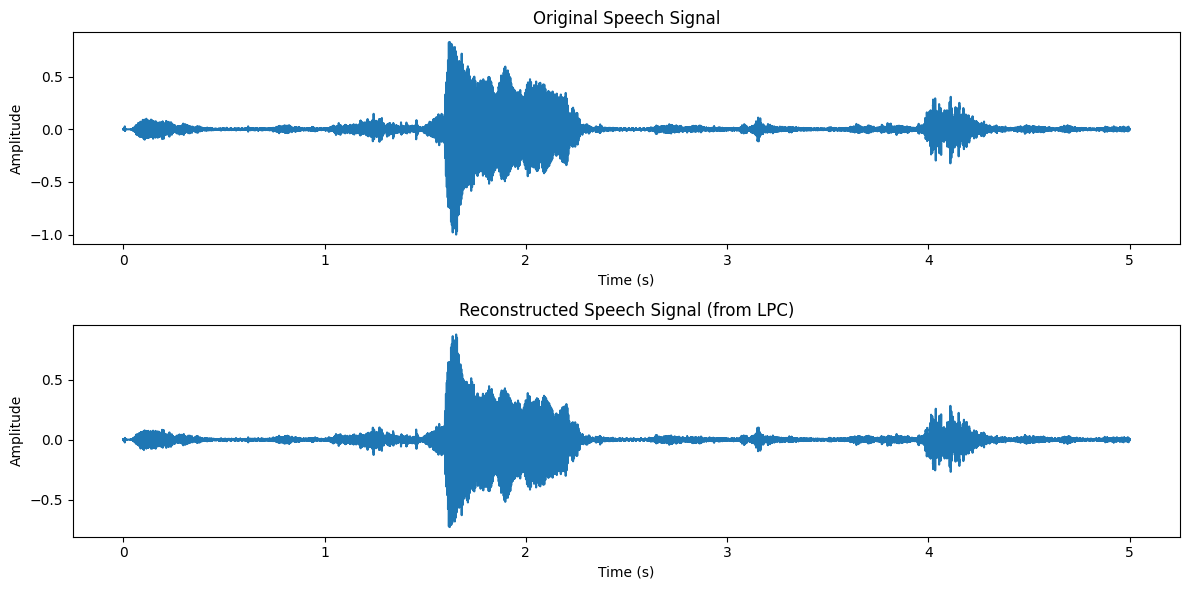

Estimated Formants: [np.float64(3927.384146423088), np.float64(6866.106907313182), np.float64(10346.021859528311), np.float64(13661.250007425127), np.float64(18199.8959235057)]


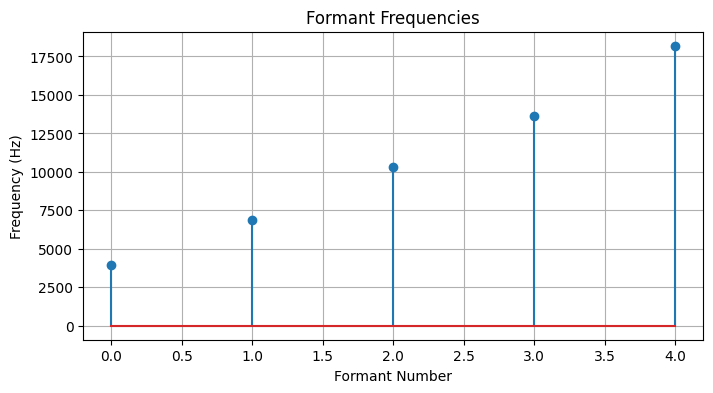

Reconstructed signal saved as 'reconstructed_signal.wav'


In [10]:
# Main execution
if __name__ == "__main__":
    audio = get_audio_choice()
    
    if audio:
        # Convert audio to numpy array for processing
        audio_samples = np.array(audio.get_array_of_samples())
        fs = audio.frame_rate  # Sampling rate
        
        # Normalize the signal
        signal = audio_samples / np.max(np.abs(audio_samples))
        
        # Perform LPC analysis
        lpc_order = 12  # You can experiment with different LPC orders
        lpc_coeffs, reconstructed_signal = lpc_analysis(signal, fs, lpc_order)
        
        # Plot original and reconstructed signals
        plot_signals(signal, reconstructed_signal, fs)
        
        # Estimate formants from LPC coefficients
        formants = estimate_formants(lpc_coeffs, fs)
        print(f"Estimated Formants: {formants}")
        
        # Plot the formant frequencies
        plot_formants(formants)
        
        # Optionally save the reconstructed signal
        sf.write('reconstructed_signal.wav', reconstructed_signal, fs)
        print("Reconstructed signal saved as 'reconstructed_signal.wav'")